In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Loading Necessary libraries 😃

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
# import keras
import re,string,unicodedata
# from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
# from keras.models import Sequential
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## Reading the dataset 😁

In [6]:
# /kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv
# /kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv

train_data = pd.read_csv('Corona_NLP_train.csv',
                        encoding='latin_1')
test_data = pd.read_csv("Corona_NLP_test.csv",encoding='latin_1')

In [7]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Check for any null value/s  😶

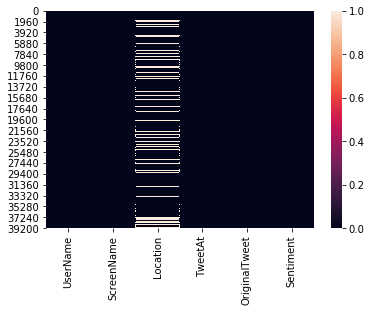

In [9]:
# check for null value in train_data
sns.heatmap(train_data.isnull());

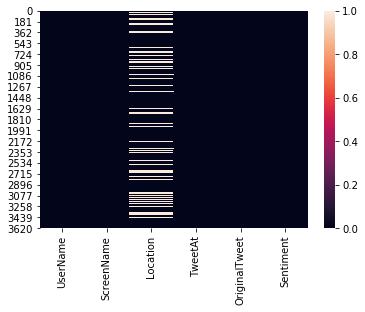

In [10]:
# check for null values in test data
sns.heatmap(test_data.isnull());

## drop duplicate and 'NA' value/s 🙄

In [11]:
train_data.drop_duplicates(inplace= True)
test_data.drop_duplicates(inplace=True)


In [12]:
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

## Making checkpoint 🧐

In [13]:
# copy the dataset into new data
train_df = train_data.copy()
test_df = test_data.copy()

In [14]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


## check if any null value exists? 🤨

In [15]:
print(train_df.isnull().sum())
print("*"*50)
print(test_df.isnull().sum())

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64
**************************************************
UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


In [16]:
train_data.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

## performing small EDA 🤩

In [17]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})

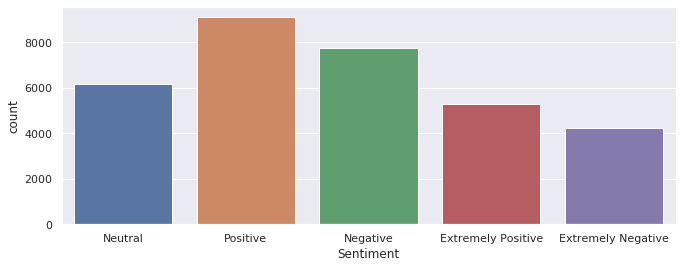

In [18]:
sns.countplot(train_df['Sentiment'])

In [19]:
train_df.shape, test_df.shape

((32567, 6), (2964, 6))

**As we can see we have 5 types of sentiment (but we can make extremely positive into positive and extremely negative into negative )**  😎

In [20]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

### Applying the change_sen function/method  😝 

In [21]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

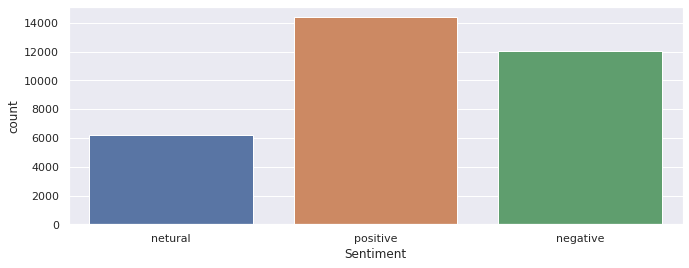

In [22]:
sns.countplot(train_df['Sentiment'])

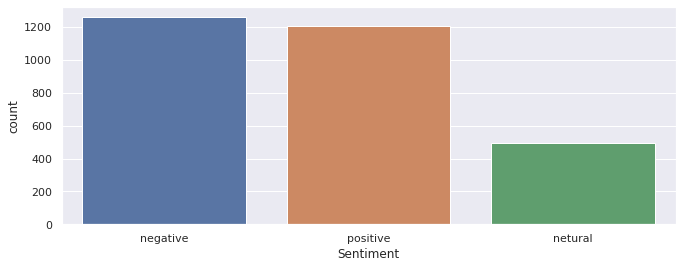

In [23]:
sns.countplot(test_df['Sentiment'])

### Now time for "Data Clearning and processing"  🤯 

In [24]:
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))

stop_words = stopwords.words('english')

def remove_urls(input_text):
    input_text=str(input_text)
    result=re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    return result

# def remove_nonASCII(string_):
#     printable = set(string.printable)
#     punctuation = set(string.punctuation)
#     #res=''.join(filter(lambda x: x not in printable, string_))
#     r = ''.join([c for c in string_ if (c in printable and c not in punctuation)])
#     return r

def remove_speChar(string):
    if '\r' in string:
        string=string.replace('\r', ' ')
    if  '\n' in string:
        string=string.replace('\n', ' ')
    return string
def clean(text):
    #     remove urls
    text = re.sub(r'http\S+', " ", text)
    #     remove mentions
    text = re.sub(r'@\w+',' ',text)
    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)
    #     remove digits
    text = re.sub(r'\d+', ' ', text)
    #     remove html tags
    text = re.sub('r<.*?>',' ', text)
    #     remove stop words 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])
    return text

In [25]:
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))





train_df['OriginalTweet']=train_df.apply(lambda row: remove_urls(row['OriginalTweet']), axis=1)
test_df['OriginalTweet']=test_df.apply(lambda row: remove_urls(row['OriginalTweet']), axis=1)
# # test_df['OriginalTweet']=train_df.apply(lambda row: remove_nonASCII(row['OriginalTweet']), axis=1)
# # test_df['OriginalTweet']=test_df.apply(lambda row: remove_nonASCII(row['OriginalTweet']), axis=1)

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean(x))
train_df['OriginalTweet']=train_df.apply(lambda row: remove_speChar(row['OriginalTweet']), axis=1)
train_ls=train_df['OriginalTweet'].tolist()

test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean(x))
test_df['OriginalTweet']=test_df.apply(lambda row: remove_speChar(row['OriginalTweet']), axis=1)
test_ls=test_df['OriginalTweet'].tolist()

In [26]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,netural
1,3800,48752,UK,16-03-2020,advice Talk neighbours family exchange phone n...,positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths give elderly...,positive
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news regionÂs first confirmed COVID- case ...,positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier grocery store sharing insights To prov...,positive


### We only need "OriginalTweet" and "Sentiment"

##### so only taking these columns

In [27]:
df_train = train_df.iloc[:,4:]
df_test = test_df.iloc[:,4:]

In [28]:
df_train.head()

,OriginalTweet,Sentiment
0,,netural
1,advice Talk neighbours family exchange phone n...,positive
2,Coronavirus Australia: Woolworths give elderly...,positive
5,As news regionÂs first confirmed COVID- case ...,positive
6,Cashier grocery store sharing insights To prov...,positive


### now mapping the sentiment  🤠 
- 0: Netural 
- 1: Positive
- 2: Negative

In [29]:
l = {"netural":0, "positive":1,"negative":2}

In [30]:
df_train['Sentiment'] = df_train['Sentiment'].map(l)
df_test['Sentiment']  = df_test['Sentiment'].map(l)

In [31]:
df_train.head()

,OriginalTweet,Sentiment
0,,0
1,advice Talk neighbours family exchange phone n...,1
2,Coronavirus Australia: Woolworths give elderly...,1
5,As news regionÂs first confirmed COVID- case ...,1
6,Cashier grocery store sharing insights To prov...,1


In [32]:
x_train = df_train['OriginalTweet'].copy()
x_test = df_test['OriginalTweet'].copy()

y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()

In [33]:
x_train.shape, y_train.shape,x_test.shape, y_test.shape

((32567,), (32567,), (2964,), (2964,))

In [34]:
x_train

0                                                         
1        advice Talk neighbours family exchange phone n...
2        Coronavirus Australia: Woolworths give elderly...
5        As news regionÂs first confirmed COVID- case ...
6        Cashier grocery store sharing insights To prov...
                               ...                        
41147                   YÂall really shitting much home??
41149    Still shocked number supermarket employees wor...
41150    I never weÂd situation &amp; world going supe...
41152    Airline pilots offering stock supermarket shel...
41156    Well new/used Rift S going $ . Amazon rn altho...
Name: OriginalTweet, Length: 32567, dtype: object

#### Maxiumn lenght of sequence  😧 

In [35]:
max_len = np.max(x_train.apply(lambda x :len(x)))
embedding_dim = 16

In [36]:
max_len

286

### Tokenizer initlization  🤑 

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_length = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

In [38]:
from nltk.tokenize import TreebankWordTokenizer
from collections import defaultdict
import nltk

In [39]:
# count frequency of words in counts; 
#create word dict:word_to_int based on counts 
def word_dict(ls, type_):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    tokenizer = TreebankWordTokenizer()
    for d in ls:
        d = tokenizer.tokenize(d)
        #d = [token for token in d if token not in stop_words]
        for w in d:
            wordCount[w] += 1
    #count is counting the word frequency and sort from most frequent to least
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    words_list = [x[1] for x in counts]
    words = set(words_list)
    vocab_to_int={w:i+1 for i,(c,w) in enumerate(counts)}
    if type_ =='v':
        return vocab_to_int
    else:
        return counts
    
#tweet int: list contains list of sentence in which words convert to numerical values
def w_to_num(vocab_to_int,ls):
    tweet_int = []
    for review in ls:
        cur_ls=[]
        for word in review.split():
            if word not in vocab_to_int.keys():
                cur_ls.append(0)
            else:
                cur_ls.append(vocab_to_int[word])
        tweet_int.append(cur_ls)
    return tweet_int

def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [40]:
# vocab_length = 31759

# x_train = w_to_num(word_dict(x_train, 'v'), x_train.tolist())
# x_test = w_to_num(word_dict(x_test, 'v'), x_test.tolist())

# x_train = pad_features(x_train, max_len)
# x_test = pad_features(x_test, max_len)

In [41]:
print("Vocab length:", vocab_length)
print("Max sequence length:", max_len)

Vocab length: 31759
Max sequence length: 286


In [42]:
# pd.DataFrame(x_train).to_csv("x_train.csv")
# pd.DataFrame(x_train).to_csv("x_test.csv")

## Model Creation  😍 

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [44]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 286, 16)           508144    
_________________________________________________________________
bidirectional (Bidirectional (None, 286, 512)          420864    
_________________________________________________________________
global_average_pooling1d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 962,035
Trainable params: 962,035
Non-trainable params: 0
__________________________________________________

In [116]:
tf.keras.utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [117]:
pip install pydot --user

Note: you may need to restart the kernel to use updated packages.


In [46]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((32567, 286), (2964, 286), (32567,), (2964,))

In [47]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

Using TensorFlow backend.


## Model training 🥱 😴

In [48]:
num_epochs = 5
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test))

Epoch 1/5
1018/1018 [==============================] - 607s 593ms/step - loss: 1.0047 - accuracy: 0.4697 - val_loss: 0.7039 - val_accuracy: 0.7055
Epoch 2/5
1018/1018 [==============================] - 602s 592ms/step - loss: 0.6347 - accuracy: 0.7596 - val_loss: 0.5608 - val_accuracy: 0.7790
Epoch 3/5
1018/1018 [==============================] - 602s 592ms/step - loss: 0.4366 - accuracy: 0.8494 - val_loss: 0.4501 - val_accuracy: 0.8411
Epoch 4/5
1018/1018 [==============================] - 601s 590ms/step - loss: 0.2839 - accuracy: 0.9121 - val_loss: 0.4955 - val_accuracy: 0.8478
Epoch 5/5
1018/1018 [==============================] - 595s 585ms/step - loss: 0.1930 - accuracy: 0.9425 - val_loss: 0.6121 - val_accuracy: 0.8323


In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## Model Accuracy and loss  😵 

In [50]:
print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")


Accuracy on training data is:- 93.82810592651367 %
Loss 20.42580097913742
Accuracy on validation data is:- 83.23211669921875 %
Loss 61.21011972427368


## Plotting  🤪 

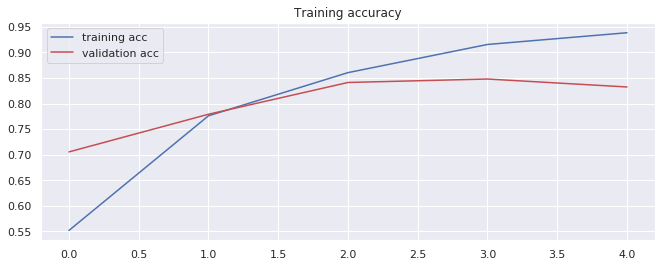

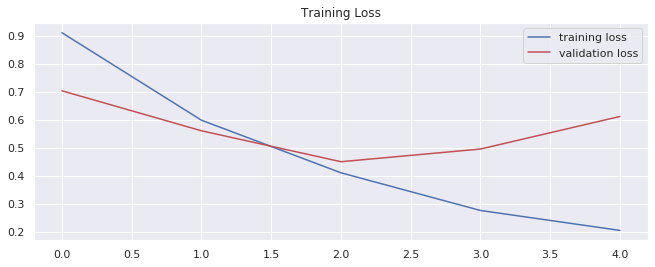

In [56]:
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.title('Training accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.title('Training Loss')
plt.legend()
plt.show()


In [57]:
pred = model.predict_classes(x_test)
pred

array([2, 1, 2, ..., 2, 0, 1])

## Confusion Matrix  🤔 

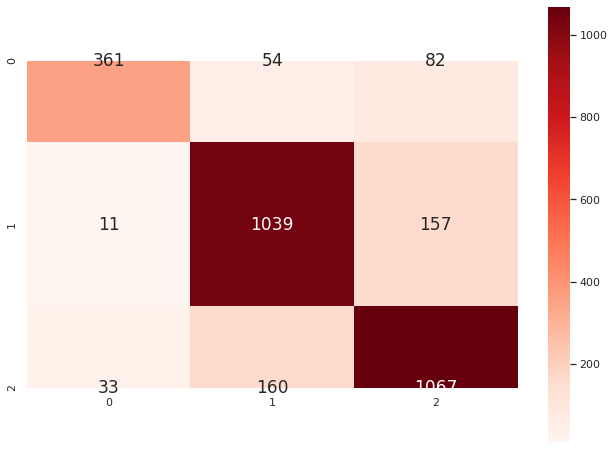

In [123]:
# cm = confusion_matrix(np.argmax(y_test,1),pred)
cm=np.array([[361,54,82],[11,1039,157],[33,160,1067]])

plt.ylabel('True')
plt.xlabel('Predicted')
sns.heatmap(cm, square= True,fmt='d',annot=True,annot_kws={'size':17}, cmap='Reds')
sns.set(rc={'figure.figsize':(11,8)})
# ax = sns.heatmap(cm, linewidth=0.5, annot=True)
# sns.heatmap(cm, annot=True)

## Classification Report  🤫 

In [85]:
print(classification_report(np.argmax(y_test,1),pred))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80       497
           1       0.83      0.86      0.84      1207
           2       0.82      0.85      0.83      1260

    accuracy                           0.83      2964
   macro avg       0.85      0.81      0.83      2964
weighted avg       0.83      0.83      0.83      2964

